In [3]:
import glob, sys
import numpy as np
import matplotlib.pyplot as plt
import time
import pyccl as ccl
cosmo = ccl.Cosmology(Omega_c = 0.30711 - 0.048254, Omega_b = 0.048254, h = 0.677, sigma8 = 0.8288, n_s=0.96)

In [4]:
%load_ext autoreload
%autoreload 2
#sys.path.append('/pbs/throng/lsst/users/cpayerne/GitForThesis/DC2Analysis/modeling/')
import CL_COUNT_class_cluster_abundance as cl_count

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


initialize the `ClusterAbundance` object

In [5]:
clc = cl_count.ClusterAbundance()
#choose the halo mass function and mass definition
massdef = ccl.halos.massdef.MassDef(200, 'critical', c_m_relation=None)
hmd = ccl.halos.hmfunc.MassFuncTinker08(cosmo, mass_def=massdef)
clc.set_cosmology(cosmo = cosmo, hmd = hmd, massdef = massdef)
clc.sky_area = (0.25)*4*np.pi

# Binned approach
Compute the 2D integral

$$
N_{\alpha\beta}^{\rm predicted} = \Omega_s\int_{z_\alpha}^{z_{\alpha + 1}} dz\int_{\log_{10}M_\beta}^{\log_{10}M_{\beta + 1}}\frac{d^2V(z)}{dz d\Omega}\frac{dn(M,z)}{d\log_{10}M}d\log_{10}M
$$

define mass & redshift binning

In [60]:
z_corner = np.linspace(0.25, 1.5, 11)
logm_corner = np.linspace(14, 15, 11)
def binning(corner): return [[corner[i],corner[i+1]] for i in range(len(corner)-1)]
Z_bin = binning(z_corner)
logMass_bin = binning(logm_corner)

Three different methods:
1. Simpson integration of a tabulated grid of $\Omega\frac{d^2V(z)}{dz d\Omega}\frac{dn(M,z)}{d\log_{10}M}$ (method `simps`)
2. Double integral using `scipy.integrate.dblquad` over a interpolated function based on a tabulated grid of $\Omega\frac{d^2V(z)}{dz d\Omega}\frac{dn(M,z)}{d\log_{10}M}$ (method `dblquad_interp`)
3. Double integral using `scipy.integrate.dblquad` of $\Omega\frac{d^2V(z)}{dz d\Omega}\frac{dn(M,z)}{d\log_{10}M}$ (method `exact_CCL`

# Mass-z

In [61]:
#define redshift-mass grid
z_grid = np.linspace(0., 3, 500)
logm_grid = np.linspace(12,16, 500)

`simps`

In [62]:
t0 = time.time()
clc.compute_multiplicity_grid_MZ(z_grid = z_grid, logm_grid = logm_grid)
Abundance_simps = clc.Cluster_Abundance_MZ(Redshift_bin = Z_bin, Proxy_bin = logMass_bin, method = 'simps')
t1 = time.time()
print('time (seconds) = ' + str(t1-t0))
time_simps = t1-t0

time (seconds) = 0.43662595748901367


In [64]:
pwd

'/pbs/throng/lsst/users/cpayerne/GitForThesis/DC2Analysis/modeling'

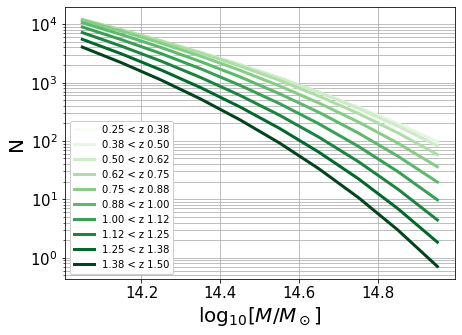

In [76]:
import matplotlib.pylab as pl
colors = plt.cm.get_cmap('Greens', len(Z_bin))
plt.figure(figsize = (7,5))
for i, z_bin in enumerate(Z_bin):
    plt.plot(np.mean(logMass_bin, axis = 1), Abundance_simps[i,:], label = f'{z_bin[0]:.2f} < z {z_bin[1]:.2f}', c = colors(i), linewidth = 3)
plt.yscale('log')
plt.xlabel(r'$\log_{10}[M/M_\odot]$', fontsize = 20)
plt.ylabel('N', fontsize = 20)
plt.legend(frameon = True, framealpha = 1)
plt.grid(True, which="both" )
plt.tick_params(axis='both', which="both", labelsize= 15)
plt.savefig('/pbs/throng/lsst/users/cpayerne/ThesisAtCCin2p3/Images/MZ.png', bbox_inches='tight', dpi=300)

# proxy-z

In [9]:
import CL_COUNT_modeling_richness as richness_model

In [10]:
#M_0, z_0
theta_pivot = [3e14/0.71, 0.6]
#\mu_0, a_\mu^z, a_\mu^M
theta_mu = [3.19, -0.7, 2]
#\sigma_0, a_\sigma^z, a_\sigma^M
theta_sigma = [0.33, 0.,-0.08]
#Richness object
richness = richness_model.Richness(theta_mu, theta_sigma, theta_pivot)

In [96]:
proxy_corner = np.linspace(0, 4, 11)
Proxy_bin = binning(proxy_corner)
clc.compute_cumulative_grid_ProxyZ(Proxy_bin = Proxy_bin, proxy_model = richness, 
                                   z_grid = z_grid, logm_grid = logm_grid)

In [97]:
time0 = time.time()
clc.compute_multiplicity_grid_MZ(z_grid = z_grid, logm_grid = logm_grid)
N_ProxyZ_simps = clc.Cluster_Abundance_ProxyZ(Redshift_bin = Z_bin, Proxy_bin = Proxy_bin, 
                                              logm_limit = [min(logm_grid), max(logm_grid)], 
                                 proxy_model = richness, method = 'simps')
time1 = time.time()
print('time (seconds) = ' + str(time1-time0))

time (seconds) = 0.35622167587280273


In [98]:
N_ProxyZ_simps[i,:]

array([4.87493008e+05, 2.47748117e+05, 1.17516555e+05, 5.10757805e+04,
       1.98655717e+04, 6.71094115e+03, 1.89636281e+03, 4.27600569e+02,
       7.25498863e+01, 8.61389336e+00])

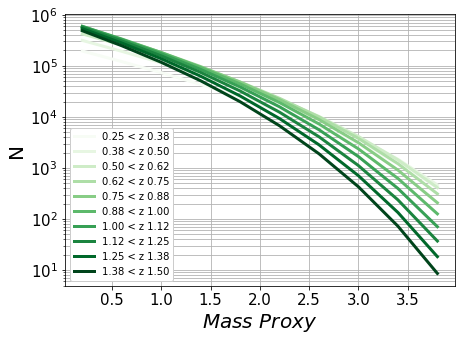

In [101]:
import matplotlib.pylab as pl
colors = plt.cm.get_cmap('Greens', len(Z_bin))
plt.figure(figsize = (7,5))
for i, z_bin in enumerate(Z_bin):
    plt.plot(np.mean(Proxy_bin, axis = 1), N_ProxyZ_simps[i,:], label = f'{z_bin[0]:.2f} < z {z_bin[1]:.2f}', c = colors(i), linewidth = 3)
plt.yscale('log')
plt.xlabel(r'$Mass\ Proxy$', fontsize = 20)
plt.ylabel('N', fontsize = 20)
plt.legend(frameon = True, framealpha = 1)
plt.grid(True, which="both" )
plt.tick_params(axis='both', which="both", labelsize= 15)
plt.savefig('/pbs/throng/lsst/users/cpayerne/ThesisAtCCin2p3/Images/MProxy.png', bbox_inches='tight', dpi=300)